# Getting basic data about number of occupations (onet)

In [2]:
#with open('onet/onet_occupation_data.csv') as f:
#with open('onet/tokenized_onet_occupation_task_statements.json') as f:
import pandas as pd
with open('onet/onet_occupation_data_filtered.csv') as f:
  num_occupation_data = len(f.readlines())

# Load Doc2Vec model

In [9]:
from gensim.models.doc2vec import Doc2Vec

#model = Doc2Vec.load('doc2vec_model_er/doc2vec_model_cont_er')
#model = Doc2Vec.load('doc2vec_model_task_statements/doc2vec_model_task_statements')
model = Doc2Vec.load('doc2vec_model_job_descriptions/doc2vec_model_job_descriptions')

# Load corpus

In [5]:
from gensim.models.doc2vec import TaggedLineDocument
#corpus = TaggedLineDocument("doc2vec_data/corpus_cont_er.cor")
#corpus = TaggedLineDocument("doc2vec_data/corpus_task_statements.cor")
corpus = TaggedLineDocument("doc2vec_data/corpus_job_descriptions.cor")

In [0]:
for idx, i in enumerate(corpus):
    print(i.tags)
    break

[0]


In [0]:
len(model.docvecs)

457277

# Assessing doc2vec model

In [4]:
def find_corpus_docs_similar_docs():
    for doc in corpus:
        doc_id = doc.tags[0]
        inferred_vector = model.infer_vector(doc.words)
        # get only top 10
        sims = model.docvecs.most_similar([inferred_vector], topn=10)
        similar_document_ids = [doc_id for doc_id, _ in sims]
        if doc_id in similar_document_ids:
            yield doc_id, similar_document_ids.index(doc_id), similar_document_ids
        else:
            yield doc_id, 999999999999, similar_document_ids # mark some dead value

In [5]:
similar_docs_gen = find_corpus_docs_similar_docs()

In [6]:
similarities = [None] * len(model.docvecs)
for similarity in similar_docs_gen:
    if similarity[0] % 10000 == 0: 
      print("Current doc ID %d" % similarity[0])
    similarities[similarity[0]] = similarity

/usr/shared/CMPT/big-data/condaenv/py36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Current doc ID 0
Current doc ID 10000
Current doc ID 20000
Current doc ID 30000
Current doc ID 40000
Current doc ID 50000
Current doc ID 60000
Current doc ID 70000
Current doc ID 80000
Current doc ID 90000
Current doc ID 100000
Current doc ID 110000
Current doc ID 120000
Current doc ID 130000
Current doc ID 140000
Current doc ID 150000
Current doc ID 160000
Current doc ID 170000
Current doc ID 180000
Current doc ID 190000
Current doc ID 200000
Current doc ID 210000
Current doc ID 220000
Current doc ID 230000
Current doc ID 240000
Current doc ID 250000
Current doc ID 260000
Current doc ID 270000
Current doc ID 280000
Current doc ID 290000
Current doc ID 300000
Current doc ID 310000
Current doc ID 320000
Current doc ID 330000
Current doc ID 340000
Current doc ID 350000
Current doc ID 360000
Current doc ID 370000
Current doc ID 380000
Current doc ID 390000
Current doc ID 400000
Current doc ID 410000
Current doc ID 420000
Current doc ID 430000
Current doc ID 440000
Current doc ID 450000


In [8]:
df = pd.DataFrame(similarities, columns=['doc_id','most_similar_index','top10_similarity_ranking'])

In [9]:
df.head(10)

,doc_id,most_similar_index,top10_similarity_ranking
0,0,0,"[0, 283460, 387791, 33999, 15, 55143, 46781, 3..."
1,1,0,"[1, 167290, 39626, 288588, 57790, 241305, 2342..."
2,2,0,"[2, 102301, 9070, 25, 287261, 349175, 44403, 9..."
3,3,0,"[3, 955, 715, 716, 316155, 545, 220662, 115075..."
4,4,0,"[4, 165911, 6, 41, 51, 259807, 7, 15, 236605, ..."
5,5,0,"[5, 349237, 30650, 244924, 52636, 168038, 2422..."
6,6,0,"[6, 203573, 0, 412604, 390417, 1, 415160, 1788..."
7,7,0,"[7, 152424, 390417, 81677, 195862, 72266, 89, ..."
8,8,0,"[8, 390798, 210064, 348834, 191000, 386825, 25..."
9,9,0,"[9, 297350, 247094, 95765, 51954, 65667, 31324..."


## Saving findings

In [10]:
#df.to_json('findings/doc2vec_er_evaluation.json.gz', orient='records', lines=True, compression='gzip')
#df.to_json('findings/doc2vec_task_statements_evaluation.json.gz', orient='records', lines=True, compression='gzip')
df.to_json('findings/doc2vec_job_descriptions_evaluation.json.gz', orient='records', lines=True, compression='gzip')

# Load evaluation

In [5]:
#ev_df = pd.read_json('findings/doc2vec_er_evaluation.json.gz', orient='records', lines=True, compression='gzip')
#ev_df = pd.read_json('findings/doc2vec_task_statements_evaluation.json.gz', orient='records', lines=True, compression='gzip')
ev_df = pd.read_json('findings/doc2vec_job_descriptions_evaluation.json.gz', orient='records', lines=True, compression='gzip')

FileNotFoundError: [Errno 2] No such file or directory: 'findings/doc2vec_job_descriptions_evaluation.json.gz'

In [4]:
import collections
ranking_counter = collections.Counter(ev_df['most_similar_index'])
ranking_counter

num = ranking_counter[0]
denom = 0
for i in range(0, 10):
    denom += ranking_counter[i] 
    
print("%f%% of the documents are self-ranked first" % ((num / denom) * 100)) 

93.940882% of the documents are self-ranked first


In [6]:
l_corpus = list(corpus)

In [7]:
# sample 10 randomly
sampled = ev_df.sample(n=10, random_state=56)

comparing_docs = sampled['top10_similarity_ranking'].transform(lambda x: list(map(lambda y: l_corpus[y], x)))

In [10]:
onet_occupation_similarity = [None] * len(model.docvecs) # make it simple, wasting space but okay

def compute_top5_onet_occupation_similarity():
  for doc in corpus:
    doc_id = doc.tags[0]
    if doc_id > num_occupation_data - 1:
      similarity = model.docvecs.most_similar(positive=[model.infer_vector(doc.words)], clip_start=0, clip_end=num_occupation_data - 1, topn=5)
      for similar_doc_id, similarity_val in similarity:
        yield doc_id, similar_doc_id, similarity_val

In [11]:
onet_similarity_gen = compute_top5_onet_occupation_similarity()

In [12]:
onet_similarity_l = list(onet_similarity_gen)

/usr/shared/CMPT/big-data/condaenv/py36/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [13]:
df = pd.DataFrame(onet_similarity_l, columns=['doc_id', 'similar_doc_id', 'similarity'])

In [19]:
df.head(20)

,doc_id,similar_doc_id,similarity
0,974,548,0.249190
1,974,385,0.229474
2,974,541,0.205969
3,974,823,0.204701
4,974,330,0.199380
5,975,658,0.231049
6,975,547,0.193516
7,975,544,0.188837
8,975,548,0.186986
9,975,407,0.184939


## Save similarities

In [14]:
#df.to_json('findings/resume_job_title_er_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')
#df.to_json('findings/resume_job_title_task_statements_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')
df.to_json('findings/resume_job_descriptions_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')

# EDA on Job Title Similarity

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Load similarities

In [12]:
similarity_df = pd.read_json('findings/resume_job_title_er_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')
#similarity_df = pd.read_json('findings/resume_job_title_task_statements_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')
#similarity_df = pd.read_json('findings/resume_job_descriptions_onet_similarity.json.gz', orient='records', lines=True, compression='gzip')

## Statistics of similarity

In [13]:
maximum = similarity_df['similarity'].max()
minimum = similarity_df['similarity'].min()
quantile_low = similarity_df['similarity'].quantile(0.25)
median = similarity_df['similarity'].median()
quantile_high = similarity_df['similarity'].quantile(0.75)
average = similarity_df['similarity'].mean()

print('Maximum similarity %f' % maximum)
print('Minimum similarity %f' % minimum)
print('25th quantile similarity %f' % quantile_low)
print('Median similarity %f' %  median)
print('75th Quantile similarity %f' % quantile_high)
print('Average similarity %f' % average)

Maximum similarity 0.909235
Minimum similarity 0.044159
25th quantile similarity 0.249983
Median similarity 0.290865
75th Quantile similarity 0.355959
Average similarity 0.320066


## Boxplot and histogram on similarity

[]

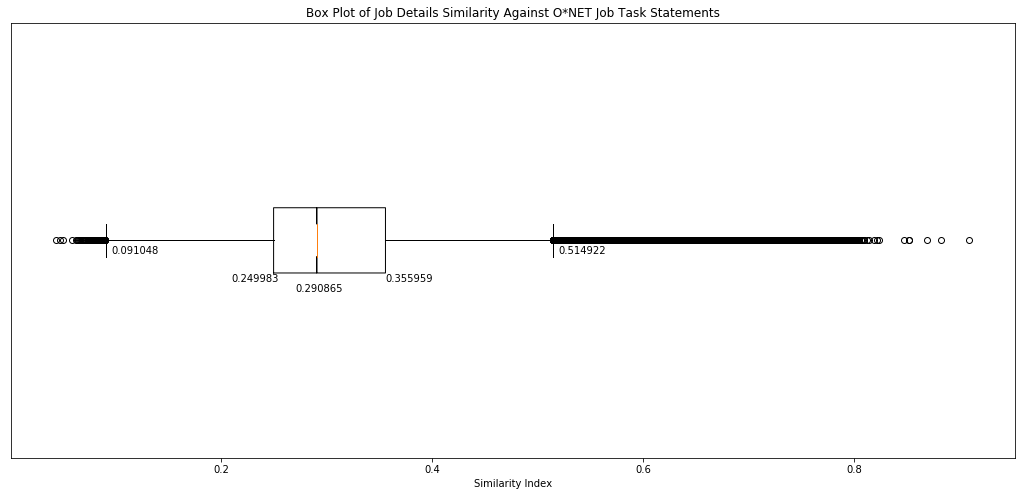

In [15]:
fig, ax = plt.subplots()

fig.set_size_inches(18, 8)
box_info = ax.boxplot(similarity_df['similarity'], notch=True, vert=False)

x, y = box_info['medians'][0].get_xydata()[0]
ax.annotate('%f' % median, (x - 0.02,y - 0.08))
x, y = box_info['boxes'][0].get_xydata()[0]
ax.annotate('%f' % quantile_low, (x - 0.04, y - 0.02))
x, y = box_info['boxes'][0].get_xydata()[6]
ax.annotate('%f' % quantile_high, (x, y - 0.02))

x, y = box_info['whiskers'][0].get_xydata()[1]
ax.annotate('%f' % box_info['whiskers'][0].get_xdata()[1], (x + 0.005, y - 0.03))

x, y = box_info['whiskers'][1].get_xydata()[1]
ax.annotate('%f' % box_info['whiskers'][1].get_xdata()[1], (x + 0.005, y - 0.03))
ax.set_title('Box Plot of Job Details Similarity Against O*NET Job Task Statements')
ax.set_xlabel('Similarity Index')
ax.set_yticks([])

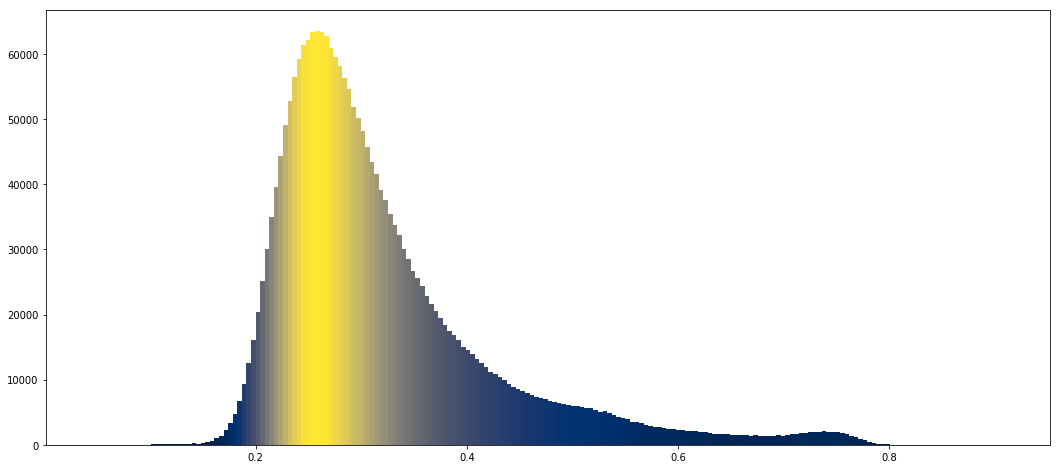

In [6]:
fig, ax = plt.subplots()

fig.set_size_inches(18, 8)
n, bins, patches = ax.hist(similarity_df['similarity'], bins=200)

# To normalize your values
cm = plt.cm.get_cmap('cividis')
col = (n-n.min())/(n.max()-n.min())
for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

## Distribution of top 5 similar ONET job descriptions

In [7]:
similar_docs_sorted = similarity_df.sort_values('similarity', ascending=False).groupby('doc_id')

In [8]:
most_similar = []
for i in range(5):
    most_similar.append(similar_docs_sorted.nth(i))

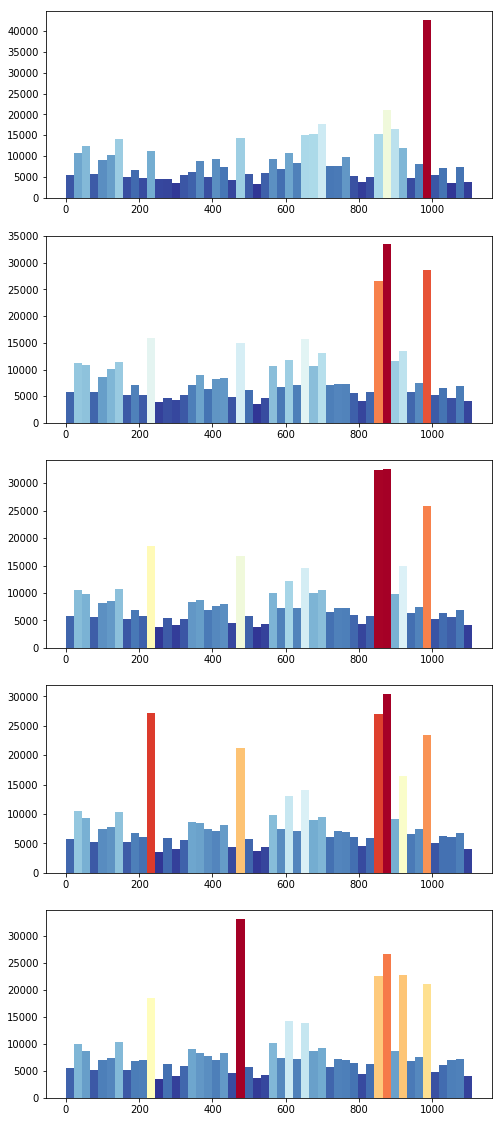

In [9]:
fig, axes = plt.subplots(5, 1)

fig.set_size_inches(8, 20)
cm = plt.cm.get_cmap('RdYlBu_r')
onet_docs_similar_bins = []
onet_docs_similar_count_values = []
for i in range(5):
    n, bins, patches = axes[i].hist(most_similar[i]['similar_doc_id'], bins=50)
    onet_docs_similar_bins.append(bins)
    onet_docs_similar_count_values.append(n)
    col = (n-n.min())/(n.max()-n.min())
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

## Finer look into the number of ONET jobs matched similar

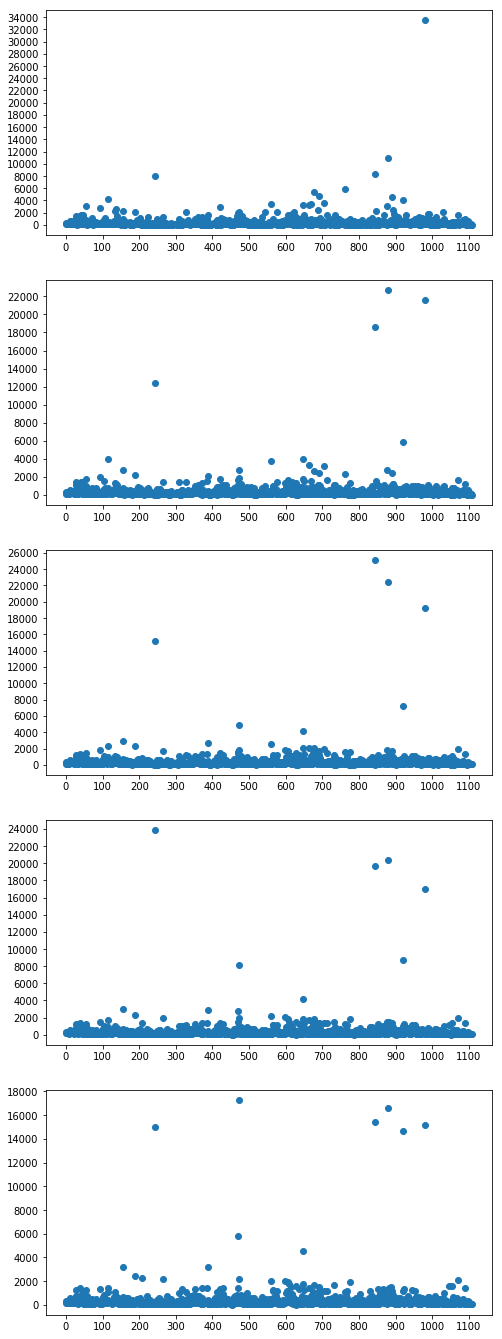

In [10]:
# course look
fig, axes = plt.subplots(5, 1)
fig.set_size_inches(8, 24)
for i in range(5):
    count_of_similar_onet_jobs = most_similar[i]['similar_doc_id'].value_counts()
    axes[i].scatter(count_of_similar_onet_jobs.index, count_of_similar_onet_jobs)
    axes[i].set_xticks(range(0, 1200, 100))
    axes[i].set_yticks(range(0, count_of_similar_onet_jobs.max() + 1000, 2000))

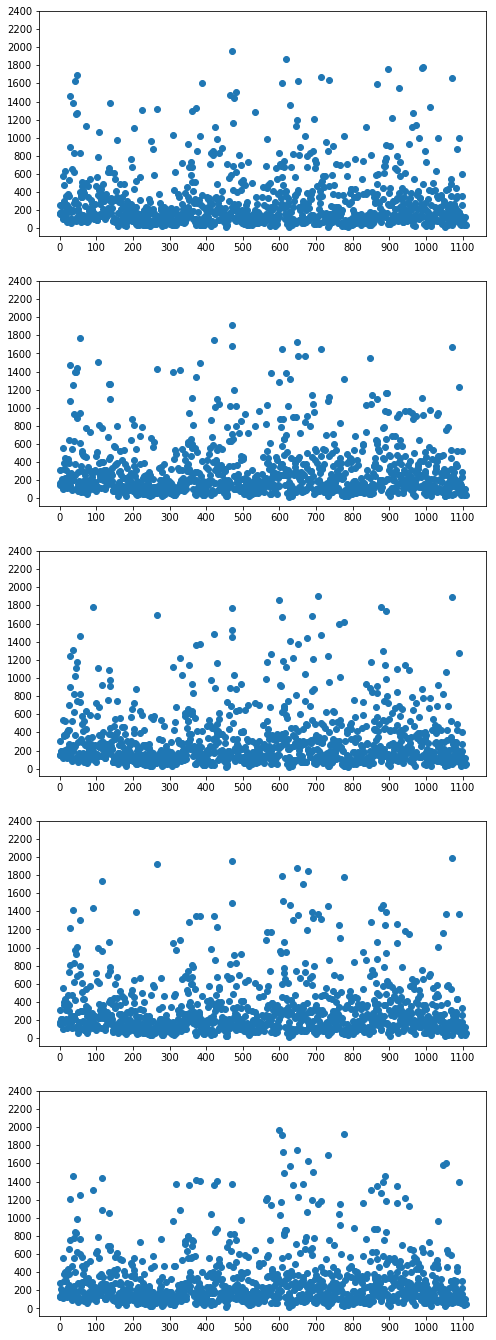

In [11]:
# take only those whose count is less than 2000, where it seems the concentration is
limit = 2000

fig, axes = plt.subplots(5, 1)
fig.set_size_inches(8, 24)
for i in range(5):
    count_of_similar_onet_jobs = most_similar[i]['similar_doc_id'].value_counts()
    filtered = count_of_similar_onet_jobs[count_of_similar_onet_jobs <= limit]
    axes[i].scatter(filtered.index, filtered)
    axes[i].set_xticks(range(0, 1200, 100))
    axes[i].set_yticks(range(0, 2500, 200))

## Loading and transforming necessary data to know the documents with some similarity

In [14]:
# get corpus mapping
from lib.load_data import read_json_from_directory

corpus_id_mapping = pd.read_csv('doc2vec_data/corpus_er_id_mapping.csv', header=None, names=['id', 'source_id'])
#corpus_id_mapping = pd.read_csv('doc2vec_data/corpus_task_statements_id_mapping.csv', header=None, names=['id', 'source_id'])

job_details_list = read_json_from_directory('er_resume_preprocessed', orient='records', lines=True, compression='gzip')
#job_details_list = read_json_from_directory('tokenized_job_details_for_doc2vec', orient='records', lines=True, compression='gzip')

/anaconda3/envs/dataworks-forge/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [15]:
job_details_list[0]

,id,job_details,job_title,resume_id
0,8589934592,"[negotiated, multi-million, dollar, contracts,...","[financial, manager]",c8316e996c572b57
1,8589934593,"[analyzed, loan, contracts, advised, negotiati...","[financial, analyst]",c8316e996c572b57
2,8589934594,"[south, iran, 7, years, secretary, board, bush...","[financial, manager]",a2bcbe6dc17b189b
3,8589934595,"[experience, following, canada, india, work, s...","[assistant, manager]",9d08ebdd92d6280f
4,8589934596,"[prepared, financial, statements, business, fo...","[financial, manager]",9d08ebdd92d6280f
5,8589934597,"[effectively, maintained, vendor, contracts, r...","[financial, lead]",3c3485cdcab43135
6,8589934598,"[effectively, created, managed, short, long-te...","[financial, advisor]",3c3485cdcab43135
7,8589934599,"[performed, budget, planning, cash, flow, supe...","[financial, manager]",3c3485cdcab43135
8,8589934600,"[whistlermy, business, experience, includes, ·...","[general, manager]",5c2bee0ca2ac2fe0
9,8589934601,"[·, high, volume, capacity, 280, ·, payroll, 2...","[financial, controller]",5c2bee0ca2ac2fe0


In [16]:
job_details = job_details_list[0]
job_details = job_details.append(job_details_list[1:]).reset_index(drop=True)

In [20]:
job_corpus_id_mapping = corpus_id_mapping.loc[num_occupation_data:]

In [22]:
job_details.id = job_details.loc[:, 'id'].astype(int)
job_corpus_id_mapping.source_id = job_corpus_id_mapping.loc[:, 'source_id'].astype(int)

## Finding documents of interest from Histogram bins

In [31]:
%%capture
# this is just code for bins of interest (basically document groupings in the above histogram graphs
# that we are interested in to inspect further)

bins_of_interest = [
    {
        "name": "most_common_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the first hist diagram is at the %d-th index"
    },
    {
        "name": "most_common_second_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the second hist diagram is at the %d-th index"
    },
    {
        "name": "second_most_common_third_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the third hist diagram is at the %d-th index"
    },
    {
        "name": "second_most_common_fourth_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the fourth hist diagram is at the %d-th index"
    },
    {
        "name": "most_common_fifth_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the fifth hist diagram is at the %d-th index"
    },
]

"""
bins_of_interest = [
    {
        "name": "most_common_most_similar",
        "bin": -1,
        "print_fmt": "The maximum value for the first hist diagram is at the %d-th index"
    },
    {
        "name": "second_most_common_second_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the second hist diagram is at the %d-th index"
    },
    {
        "name": "second_most_common_third_most_similar",
        "bin": -2,
        "print_fmt": "The second highest value for the third hist diagram is at the %d-th index"
    },
    {
        "name": "fourth_most_common_fourth_most_similar",
        "bin": -4,
        "print_fmt": "The fourth highest value for the fourth hist diagram is at the %d-th index"
    },
    {
        "name": "second_common_fifth_most_similar",
        "bin": -5,
        "print_fmt": "The fifth highest for the fifth hist diagram is at the %d-th index"
    },
]
"""

In [32]:
import numpy as np

# take different kinds of maximum to spread out the document checks

doc_range_of_interest = []
for idx, interest in enumerate(bins_of_interest):
    argmax = onet_docs_similar_count_values[idx].argpartition(interest['bin'])[interest['bin']]
    print(interest['print_fmt'] % argmax)
    doc_range_of_interest.append((interest['name'], argmax - 1, argmax))

The maximum value for the first hist diagram is at the 44-th index
The maximum value for the second hist diagram is at the 39-th index
The second highest value for the third hist diagram is at the 38-th index
The second highest value for the fourth hist diagram is at the 10-th index
The maximum value for the fifth hist diagram is at the 21-th index


## Storing job documents along with similar ONET jobs

In [44]:
def merge_onet_data_with_corpus_mapping(onet_data_path, onet_key, reader_func=pd.read_csv, **kwargs):
    onet_data = reader_func(onet_data_path, **kwargs)
    onet_data = onet_data.merge(corpus_id_mapping[:num_occupation_data], how='inner', left_on=onet_key, right_on='source_id')
    return onet_data

In [46]:
merged_onet_data = merge_onet_data_with_corpus_mapping('onet/onet_occupation_data.csv', 'O*NET-SOC Code', reader_func=pd.read_csv)
#merged_onet_data = merge_onet_data_with_corpus_mapping('onet/tokenized_onet_occupation_task_statements.json', 'onet_job_id', reader_func=pd.read_json, orient='records', lines=True)

In [47]:
def merge_job_details_with_corpus_mapping(job_details, job_key):
    # merging corpus ID mapping with job_details
    job_details = job_details.rename({job_key:'job_id'}, axis='columns')
    job_details = job_details.merge(job_corpus_id_mapping, how='inner', left_on='job_id', right_on = 'source_id')
    return job_details

In [48]:
merged_job_details = merge_job_details_with_corpus_mapping(job_details, 'id')

### Saving documents of interest from above

In [49]:
from math import ceil, floor

def get_similar_documents_of_interest(docs_interested, desired_keys):
    # getting some samples
    similar_document_checks = {}
    for idx, interest in enumerate(doc_range_of_interest):
        interest_name = interest[0]
        low_idx = interest[1]
        high_idx = interest[2]

        low_range = ceil(onet_docs_similar_bins[idx][low_idx])
        high_range = floor(onet_docs_similar_bins[idx][high_idx])
        where = (most_similar[idx].similar_doc_id >= low_range) & (most_similar[idx].similar_doc_id <= high_range)
        df_sampled_similarities = most_similar[idx].loc[where, ['similar_doc_id', 'similarity']].sample(n=100, random_state=42)
        df_sampled_similarities = df_sampled_similarities.reset_index()
        df_sampled_similarities.similar_doc_id = df_sampled_similarities.similar_doc_id.astype(int)
        df_sampled_similarities = df_sampled_similarities.merge(merged_onet_data, how='inner', left_on='similar_doc_id', right_on='id')
        # avoid colum conflict
        df_sampled_similarities = df_sampled_similarities.drop('id', axis='columns')

        # merge and get relevant info
        merged_similar_jobs_with_info = merged_job_details.merge(df_sampled_similarities, how='inner', left_on='id', right_on='doc_id')
        merged_similar_jobs_with_info = merged_similar_jobs_with_info[desired_keys]

        # store
        similar_document_checks[interest_name] = merged_similar_jobs_with_info
    return similar_document_checks

In [51]:
# this is for data from ER stage
desired_keys = ['Title', 'Description', 'job_title', 'job_details', 'similarity']

# this is for data as task statements
# desired_keys = ['onet_job_title', 'task', 'job_title', 'tokenized_details', 'similarity']

similar_documents_of_interest = get_similar_documents_of_interest(doc_range_of_interest, desired_keys)

In [54]:
import os

# again for data from ER stage
filename_fmt = 'er_doc2vec_docs_results_%s.json'

# this is for data as task statements
#filename_fmt = 'task_statements_doc2vec_docs_results_%s.json'

for interest_name, similar_documents in similar_documents_of_interest.items():
    similar_documents.to_json(os.path.join('findings', filename_fmt % interest_name), orient='records', lines=True)

### Saving most similar documents with similarity threshold

In [55]:
threshold = 0.5
top_most_similar = most_similar[0]
filtered_top_most_similar = top_most_similar[top_most_similar.similarity > threshold].reset_index()
print("Number of similar job details and O*NET data is %d with similarity above %f" % (len(filtered_top_most_similar), threshold))

Number of similar job details and O*NET data is 43091 with similarity above 0.500000


In [59]:
merged_filtered_top_most_similar = filtered_top_most_similar.merge(merged_onet_data, how='inner', left_on='similar_doc_id', right_on='id')
merged_filtered_top_most_similar = merged_filtered_top_most_similar.merge(merged_job_details, how='inner', left_on='doc_id', right_on='job_id')

# for ER
columns = ['O*NET-SOC Code', 'resume_id', 'Title', 'job_title', 'Description', 'job_details', 'similarity']

# for task statements
#columns = ['onet_job_id', 'resume_id', 'onet_job_title', 'job_title', 'task', 'tokenized_details', 'similarity']
merged_filtered_top_most_similar = merged_filtered_top_most_similar[columns]
merged_filtered_top_most_similar

,O*NET-SOC Code,resume_id,Title,job_title,Description,job_details,similarity
0,27-1029.00,11044b52a95ab353,"Designers, All Other","[ios, software, engineer]",All designers not listed separately.,"[poland, built, developed, iphone, ipad, appli...",0.633955
1,27-1029.00,6d7884d477f7b890,"Designers, All Other","[asst, project, manager]",All designers not listed separately.,"[application, owner, leading, project, technic...",0.567957
2,47-5049.00,5bcb9b442ab85253,"Mining Machine Operators, All Other","[android, developer]",All mining machine operators not listed separa...,"[house, 116, lane, 6, 4th, floor, new, dohs, m...",0.500975
3,47-5049.00,fd04c4ebc31465c5,"Mining Machine Operators, All Other","[senior, software, developer]",All mining machine operators not listed separa...,"[project, title, enterprise, supplier, managem...",0.566736
4,47-5049.00,a84287317b5caca3,"Mining Machine Operators, All Other","[software, engineer]",All mining machine operators not listed separa...,"[devon, united, kingdom, developed, applicatio...",0.521240
5,47-5049.00,a84287317b5caca3,"Mining Machine Operators, All Other","[placement, student]",All mining machine operators not listed separa...,"[devon, united, kingdom, developed, applicatio...",0.526727
6,47-5049.00,10ab43de6bde61fe,"Mining Machine Operators, All Other",[contractor],All mining machine operators not listed separa...,"[worked, freelancer, following, objectives, ‧,...",0.614202
7,47-5049.00,b8e6b2442fcd0da7,"Mining Machine Operators, All Other","[senior, software, engineer]",All mining machine operators not listed separa...,"[6+, years, worked, senior, software, engineer...",0.603329
8,47-5049.00,d7e7766e14b96c0c,"Mining Machine Operators, All Other","[software, embedded, software, engineer]",All mining machine operators not listed separa...,"[burnaby, canada, provides, portable, customiz...",0.658581
9,47-5049.00,d7e7766e14b96c0c,"Mining Machine Operators, All Other","[embedded, software, engineer]",All mining machine operators not listed separa...,"[functions, involved, develop, embedded, banki...",0.544958


In [60]:
# save the results
import os

# for data from ER
file_name = 'top_most_similar_jobs_er.json'

# for data as task statements
#file_name = 'top_most_similar_jobs_task_statements.json'

merged_filtered_top_most_similar.to_json(os.path.join('findings', file_name), orient='records', lines='True')